In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [32]:
from transformers import AutoTokenizer
from transformers import BertModel  # https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertModel
from transformers import RobertaModel  # https://huggingface.co/docs/transformers/model_doc/roberta#transformers.RobertaModel
from transformers import DistilBertModel  # https://huggingface.co/docs/transformers/model_doc/distilbert#transformers.DistilBertModel


def get_model(model_name):
    assert model_name in ['bert', 'roberta', 'distilbert']
    
    checkpoint_names = {
        'bert': 'bert-base-cased',  # https://huggingface.co/bert-base-cased
        'roberta': 'roberta-base',  # https://huggingface.co/roberta-base
        'distilbert': 'distilbert-base-cased'  # https://huggingface.co/distilbert-base-cased
    }
    
    model_classes = {
        'bert': BertModel,
        'roberta': RobertaModel,
        'distilbert': DistilBertModel
    }
    
    return AutoTokenizer.from_pretrained(checkpoint_names[model_name]), model_classes[model_name].from_pretrained(checkpoint_names[model_name])

In [33]:
pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [34]:
import os
import pickle
from catboost import CatBoostClassifier
import pandas as pd
from sqlalchemy import create_engine

def get_model_path(path: str) -> str:
    if os.environ.get("IS_LMS") == "1":  # проверяем где выполняется код в лмс, или локально. Немного магии
        MODEL_PATH = '/workdir/user_input/model'
    else:
        MODEL_PATH = path
    return MODEL_PATH

def load_models():
    from_file = CatBoostClassifier()
    # LOAD MODEL HERE PLS :)
    loaded_model = from_file.load_model(get_model_path("catboost_model"))
    return loaded_model

def batch_load_sql(query: str) -> pd.DataFrame:
    CHUNKSIZE = 200000
    engine = create_engine(
        "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
        "postgres.lab.karpov.courses:6432/startml"
    )
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

In [35]:
feed_data_limit = 200000
user_data_limit = 163205#114903 163205
post_text_limit = 7023#6924 7023

In [36]:
%%time
from sklearn.decomposition import PCA 
user_data = batch_load_sql(f"SELECT * FROM public.user_data LIMIT {user_data_limit}")
user_data = user_data.iloc[user_data.drop('user_id', axis=1).drop_duplicates().index.tolist()]

CPU times: user 902 ms, sys: 115 ms, total: 1.02 s
Wall time: 7.86 s


In [37]:
from category_encoders import BinaryEncoder

one_hot_columns = ['gender', 'os', 'exp_group', 'source']
dummies = pd.get_dummies(user_data[one_hot_columns].astype(object))
user_data[dummies.columns.to_list()] = dummies


binary_encoder = BinaryEncoder(cols=['age', 'city'])
new_data = binary_encoder.fit_transform(user_data[['age', 'city']])
user_data = pd.concat([user_data, new_data], axis = 1)

user_data = user_data.drop(['gender', 'exp_group', 'os', 'source', 'country', 'city', 'age'], axis=1)
user_data

,user_id,gender_0,gender_1,os_Android,os_iOS,exp_group_0,exp_group_1,exp_group_2,exp_group_3,exp_group_4,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,200,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,201,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,202,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,203,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,204,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163197,168545,0,1,0,1,0,0,0,0,1,...,0,0,1,0,1,1,1,1,1,1
163198,168546,0,1,1,0,0,0,0,0,1,...,1,1,0,0,1,1,0,0,0,0
163200,168548,1,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,1,0,1,0
163202,168550,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0


In [38]:
%%time
post_text = batch_load_sql(f"SELECT * FROM public.post_text_df LIMIT {post_text_limit}")
post_text = post_text.iloc[post_text.drop('post_id', axis=1).drop_duplicates().index.tolist()].dropna()

CPU times: user 61.9 ms, sys: 10.4 ms, total: 72.3 ms
Wall time: 5.78 s


In [39]:
from category_encoders import BinaryEncoder

one_hot_columns = ['topic'] 
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object)) 
post_text[dummies.columns.to_list()] = dummies

In [40]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tf = TfidfVectorizer(max_features=50).fit_transform(post_text['text'])
svd = TruncatedSVD(n_components=20, random_state=42)
X_svd = svd.fit_transform(tf)

CPU times: user 1.15 s, sys: 15.1 ms, total: 1.16 s
Wall time: 1.15 s


from transformers import BertTokenizer
tokenizer, model = get_model('bert')
max_length = 20
embeddings = torch.empty(max_length, 1)
for index,row in post_text.iterrows():
    encoding = tokenizer.encode_plus(row['text'], add_special_tokens=True, return_token_type_ids=False, return_tensors='pt', truncation=True, max_length=max_length,padding='max_length')
    embeddings = torch.cat((embeddings, encoding['input_ids'][0].unsqueeze(1)), 1)

embedding = pd.DataFrame(StandardScaler().fit_transform(embeddings)).T.iloc[1:]
embedding.index = post_text.index
post_text = pd.concat([embedding, post_text], axis=1).drop('text', axis=1)

In [41]:
X_svd_df = pd.DataFrame(X_svd)
X_svd_df.index = post_text.index
post_text = pd.concat([X_svd_df, post_text], axis=1).drop('text',axis=1)

#test
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(post_text['text'])

tfidf_tokens = vectorizer.get_feature_names_out()

post_text['tf_idf'] = pd.DataFrame(
    data=X.toarray(), 
    index=[i for i in range(X.shape[0])], 
    columns=tfidf_tokens
).sum(axis=1)

from category_encoders import BinaryEncoder

one_hot_columns = ['topic']
dummies = pd.get_dummies(post_text[one_hot_columns].astype(object))
post_text[dummies.columns.to_list()] = dummies

from sklearn.preprocessing import StandardScaler

post_text = post_text.dropna().drop('topic', axis=1)

scaler = StandardScaler()
scaler.fit(post_text['tf_idf'].to_frame())
post_text['tf_idf'] = scaler.transform(post_text['tf_idf'].to_frame())

In [42]:
post_text

,0,1,2,3,4,5,6,7,8,9,...,19,post_id,topic,topic_business,topic_covid,topic_entertainment,topic_movie,topic_politics,topic_sport,topic_tech
0,0.902746,-0.288730,-0.080188,-0.012387,-0.014206,0.038608,0.025506,0.100735,-0.070104,0.047299,...,-0.047655,1,business,1,0,0,0,0,0,0
1,0.871287,-0.299500,0.062931,-0.059613,0.065203,-0.014530,-0.026368,0.099627,0.023172,0.019062,...,-0.012380,2,business,1,0,0,0,0,0,0
2,0.880943,-0.214751,-0.129139,0.003369,0.024576,0.101719,-0.055445,0.073982,-0.068585,-0.040101,...,0.102764,3,business,1,0,0,0,0,0,0
3,0.869847,-0.278410,-0.132046,-0.034545,-0.081083,-0.043745,0.046410,0.029502,-0.080028,-0.083941,...,0.063968,4,business,1,0,0,0,0,0,0
4,0.798251,-0.333808,0.163789,-0.065548,-0.033611,0.060267,0.020682,0.009914,-0.026235,-0.011087,...,0.206413,5,business,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,0.610402,0.371799,0.046985,-0.142482,-0.347160,0.060692,-0.107001,-0.199601,0.014022,-0.018209,...,0.035170,7315,movie,0,0,0,1,0,0,0
7019,0.723518,0.261655,0.069334,-0.099280,-0.219379,-0.180873,0.017279,0.049003,-0.112982,0.073444,...,-0.065689,7316,movie,0,0,0,1,0,0,0
7020,0.551869,0.263151,-0.030861,-0.032985,0.104855,-0.041863,0.083975,-0.131060,-0.045465,0.026825,...,0.007578,7317,movie,0,0,0,1,0,0,0
7021,0.679564,0.286984,-0.066778,-0.086734,-0.243029,-0.064924,0.019225,-0.120725,0.090747,-0.113168,...,-0.132006,7318,movie,0,0,0,1,0,0,0


In [43]:
%%time
feed_data = batch_load_sql(f"SELECT * FROM public.feed_data LIMIT {feed_data_limit}")

feed_data

CPU times: user 877 ms, sys: 54.6 ms, total: 931 ms
Wall time: 8.21 s


,timestamp,user_id,post_id,action,target
0,2021-12-05 22:58:15,107494,5027,view,0
1,2021-12-05 22:58:49,107494,3243,view,0
2,2021-12-05 22:59:58,107494,3713,view,0
3,2021-12-05 23:01:54,107494,2067,view,0
4,2021-12-05 23:02:11,107494,6797,view,0
...,...,...,...,...,...
199995,2021-10-28 09:25:06,28370,2361,view,1
199996,2021-10-28 09:27:53,28370,2361,like,0
199997,2021-10-28 09:27:55,28370,106,view,0
199998,2021-10-28 09:28:11,28370,7042,view,0


In [44]:
df = post_text.merge(feed_data, how='inner', on='post_id').merge(user_data, how='inner', on='user_id').drop_duplicates()
#pred = feed_data.merge(user_data, how='inner', on='user_id')
#df = post_text.merge(pred, how='inner', on='post_id' )
#user_data_limit = 25000
#post_data_limit = 400

#df = post_text[:post_data_limit].merge(user_data[:user_data_limit], how='cross').merge(feed_data, how='inner', on=['user_id', 'post_id'])

In [45]:
df

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,0.902746,-0.288730,-0.080188,-0.012387,-0.014206,0.038608,0.025506,0.100735,-0.070104,0.047299,...,1,0,0,0,0,0,1,1,1,1
1,0.087797,0.055311,0.086677,-0.027731,-0.017742,-0.056358,-0.042916,0.036804,0.086157,-0.042100,...,1,0,0,0,0,0,1,1,1,1
2,0.573031,-0.246085,0.118848,-0.166195,0.200518,-0.273053,-0.076075,-0.072097,-0.095408,0.095490,...,1,0,0,0,0,0,1,1,1,1
3,0.866332,-0.274014,-0.160069,0.058105,-0.133929,0.000390,0.032761,0.039201,-0.098178,-0.083462,...,1,0,0,0,0,0,1,1,1,1
4,0.889391,-0.299113,-0.070797,0.077235,-0.025371,-0.102537,0.045616,0.052270,-0.118721,-0.024565,...,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153117,0.442735,0.384177,-0.059732,0.072597,-0.051041,0.091976,0.010955,0.396157,0.193079,-0.075709,...,0,0,0,0,1,1,0,1,1,0
153118,0.738669,0.086527,0.132360,-0.008820,0.143920,0.039183,-0.078578,0.343853,0.118231,0.028385,...,0,0,0,0,1,1,0,1,1,0
153119,0.891487,0.114524,-0.201195,-0.089351,0.001300,-0.007925,0.051861,0.162621,-0.019872,0.006884,...,0,0,0,0,1,1,0,1,1,0
153120,0.723518,0.261655,0.069334,-0.099280,-0.219379,-0.180873,0.017279,0.049003,-0.112982,0.073444,...,0,0,0,0,1,1,0,1,1,0


In [46]:
df = df.apply(lambda x:x.fillna(x.value_counts().index[0]))

In [47]:
df_copy = df.copy()
df_copy

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,0.902746,-0.288730,-0.080188,-0.012387,-0.014206,0.038608,0.025506,0.100735,-0.070104,0.047299,...,1,0,0,0,0,0,1,1,1,1
1,0.087797,0.055311,0.086677,-0.027731,-0.017742,-0.056358,-0.042916,0.036804,0.086157,-0.042100,...,1,0,0,0,0,0,1,1,1,1
2,0.573031,-0.246085,0.118848,-0.166195,0.200518,-0.273053,-0.076075,-0.072097,-0.095408,0.095490,...,1,0,0,0,0,0,1,1,1,1
3,0.866332,-0.274014,-0.160069,0.058105,-0.133929,0.000390,0.032761,0.039201,-0.098178,-0.083462,...,1,0,0,0,0,0,1,1,1,1
4,0.889391,-0.299113,-0.070797,0.077235,-0.025371,-0.102537,0.045616,0.052270,-0.118721,-0.024565,...,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153117,0.442735,0.384177,-0.059732,0.072597,-0.051041,0.091976,0.010955,0.396157,0.193079,-0.075709,...,0,0,0,0,1,1,0,1,1,0
153118,0.738669,0.086527,0.132360,-0.008820,0.143920,0.039183,-0.078578,0.343853,0.118231,0.028385,...,0,0,0,0,1,1,0,1,1,0
153119,0.891487,0.114524,-0.201195,-0.089351,0.001300,-0.007925,0.051861,0.162621,-0.019872,0.006884,...,0,0,0,0,1,1,0,1,1,0
153120,0.723518,0.261655,0.069334,-0.099280,-0.219379,-0.180873,0.017279,0.049003,-0.112982,0.073444,...,0,0,0,0,1,1,0,1,1,0


In [48]:
df_copy.drop(['timestamp', 'target', 'action', 'post_id', 'user_id'], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,0.902746,-0.288730,-0.080188,-0.012387,-0.014206,0.038608,0.025506,0.100735,-0.070104,0.047299,...,1,0,0,0,0,0,1,1,1,1
1,0.087797,0.055311,0.086677,-0.027731,-0.017742,-0.056358,-0.042916,0.036804,0.086157,-0.042100,...,1,0,0,0,0,0,1,1,1,1
2,0.573031,-0.246085,0.118848,-0.166195,0.200518,-0.273053,-0.076075,-0.072097,-0.095408,0.095490,...,1,0,0,0,0,0,1,1,1,1
3,0.866332,-0.274014,-0.160069,0.058105,-0.133929,0.000390,0.032761,0.039201,-0.098178,-0.083462,...,1,0,0,0,0,0,1,1,1,1
4,0.889391,-0.299113,-0.070797,0.077235,-0.025371,-0.102537,0.045616,0.052270,-0.118721,-0.024565,...,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153117,0.442735,0.384177,-0.059732,0.072597,-0.051041,0.091976,0.010955,0.396157,0.193079,-0.075709,...,0,0,0,0,1,1,0,1,1,0
153118,0.738669,0.086527,0.132360,-0.008820,0.143920,0.039183,-0.078578,0.343853,0.118231,0.028385,...,0,0,0,0,1,1,0,1,1,0
153119,0.891487,0.114524,-0.201195,-0.089351,0.001300,-0.007925,0.051861,0.162621,-0.019872,0.006884,...,0,0,0,0,1,1,0,1,1,0
153120,0.723518,0.261655,0.069334,-0.099280,-0.219379,-0.180873,0.017279,0.049003,-0.112982,0.073444,...,0,0,0,0,1,1,0,1,1,0


In [49]:
from torch.utils.data import Dataset
df_to_dataset = df_copy.drop(['timestamp', 'action', 'post_id', 'user_id', 'topic'], axis=1)
df_to_dataset

,0,1,2,3,4,5,6,7,8,9,...,city_2,city_3,city_4,city_5,city_6,city_7,city_8,city_9,city_10,city_11
0,0.902746,-0.288730,-0.080188,-0.012387,-0.014206,0.038608,0.025506,0.100735,-0.070104,0.047299,...,1,0,0,0,0,0,1,1,1,1
1,0.087797,0.055311,0.086677,-0.027731,-0.017742,-0.056358,-0.042916,0.036804,0.086157,-0.042100,...,1,0,0,0,0,0,1,1,1,1
2,0.573031,-0.246085,0.118848,-0.166195,0.200518,-0.273053,-0.076075,-0.072097,-0.095408,0.095490,...,1,0,0,0,0,0,1,1,1,1
3,0.866332,-0.274014,-0.160069,0.058105,-0.133929,0.000390,0.032761,0.039201,-0.098178,-0.083462,...,1,0,0,0,0,0,1,1,1,1
4,0.889391,-0.299113,-0.070797,0.077235,-0.025371,-0.102537,0.045616,0.052270,-0.118721,-0.024565,...,1,0,0,0,0,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153117,0.442735,0.384177,-0.059732,0.072597,-0.051041,0.091976,0.010955,0.396157,0.193079,-0.075709,...,0,0,0,0,1,1,0,1,1,0
153118,0.738669,0.086527,0.132360,-0.008820,0.143920,0.039183,-0.078578,0.343853,0.118231,0.028385,...,0,0,0,0,1,1,0,1,1,0
153119,0.891487,0.114524,-0.201195,-0.089351,0.001300,-0.007925,0.051861,0.162621,-0.019872,0.006884,...,0,0,0,0,1,1,0,1,1,0
153120,0.723518,0.261655,0.069334,-0.099280,-0.219379,-0.180873,0.017279,0.049003,-0.112982,0.073444,...,0,0,0,0,1,1,0,1,1,0


In [50]:
df_to_dataset.dtypes

0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
9                      float64
10                     float64
11                     float64
12                     float64
13                     float64
14                     float64
15                     float64
16                     float64
17                     float64
18                     float64
19                     float64
topic_business           uint8
topic_covid              uint8
topic_entertainment      uint8
topic_movie              uint8
topic_politics           uint8
topic_sport              uint8
topic_tech               uint8
target                   int64
gender_0                 uint8
gender_1                 uint8
os_Android               uint8
os_iOS                   uint8
exp_grou

In [51]:
class CustomDataset(Dataset):
    def __init__(self, df):
        self.labels = torch.tensor(df[['target']].to_numpy().reshape(-1)).float()
        #self.labels = torch.full((df.shape[0], 6924), 0.5)
        self.dataset = torch.tensor(df.drop('target', axis=1).values).float()

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx] 

In [52]:
dataset = CustomDataset(df_to_dataset)
dataset.__getitem__(3649)[0].shape

torch.Size([57])

In [61]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.dropout = nn.Sequential(
            nn.Dropout(p=0.2)
        )
        n = 32
        self.block1 = nn.Sequential(
            nn.Linear(input_size, n), 
            nn.BatchNorm1d(n),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(n, n * 2), 
            nn.BatchNorm1d(n * 2),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.Linear(n * 2, n * 2), 
            nn.BatchNorm1d(n * 2),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Linear(n * 2, n * 4), 
            nn.BatchNorm1d(n * 4),
            nn.ReLU()
        )
        self.block5 = nn.Sequential(
            nn.Linear(n * 4, n * 4), 
            nn.BatchNorm1d(n * 4),
            nn.ReLU()
        )
        self.block6 = nn.Sequential(
            nn.Linear(n * 4, n * 8), 
            nn.BatchNorm1d(n * 8),
            nn.ReLU()
        )
        self.block7 = nn.Sequential(
            nn.Linear(n * 8, n * 8), 
            nn.BatchNorm1d(n * 8),
            nn.ReLU()
        )
        self.block8 = nn.Sequential(
            nn.Linear(n * 8, n * 16), 
            nn.BatchNorm1d(n * 16),
            nn.ReLU()
        )
        self.block9 = nn.Sequential(
            nn.Linear(n * 16, n * 16), 
            nn.BatchNorm1d(n * 16),
            nn.ReLU()
        )
        self.block10 = nn.Sequential(
            nn.Linear(n * 16, 1),
            #nn.Softmax(dim=0)
            #nn.Sigmoid()
            nn.Tanh()
        )

    def forward(self, x):
        output = self.block1(x)
        output = self.block2(output)
        output = self.dropout(output)
        output = self.block3(output) + output
        output = self.dropout(output)
        output = self.block4(output)
        output = self.dropout(output)
        output = self.block5(output) + output
        output = self.dropout(output)
        output = self.block6(output)
        output = self.dropout(output)
        output = self.block7(output) + output
        output = self.dropout(output)
        output = self.block8(output)
        output = self.dropout(output)
        output = self.block9(output) + output
        output = self.dropout(output)
        output = self.block10(output)
        

        return output

In [73]:
#!g1.1
from tqdm import tqdm


def train(model, train_loader) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        optimizer.zero_grad()

        output = model(x.float())
        
        #print(output, y)
        
        loss = loss_fn(output, y)
        
        train_loss += loss.item()

        loss.backward()

        total += y.size(0)
        correct += (output == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [74]:
#!g1.1
@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.unsqueeze(1).to(device)
        
        
        output = model(x.float())
        loss = loss_fn(output, y)

        total_loss += loss.item()

        #_, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (output == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [75]:
#!g1.1
from IPython.display import clear_output
import matplotlib.pyplot as plt

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    #plt.figure(figsize=(16, 8))

    #plt.title(title + ' accuracy')
    
    #plt.plot(train_accuracy, label='Train accuracy')
    #plt.plot(valid_accuracy, label='Valid accuracy')
    #plt.legend()
    #plt.grid()

    #plt.show()

In [80]:
def whole_train_valid_cycle(model, num_epochs, title, train_loader, valid_loader):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)
        
        if epoch % 25 == 0:
            torch.save(model.state_dict(), f'net_{epoch}')
        
        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        #scheduler.step()

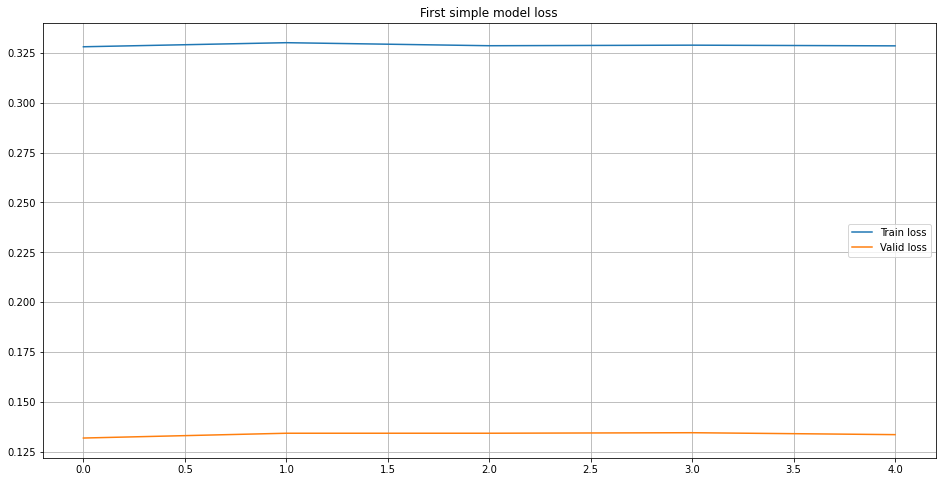

In [81]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CyclicLR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=2048, shuffle=True, num_workers=2, pin_memory=True)


net = Net(df_to_dataset.shape[1] - 1).to(device)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

#scheduler = CyclicLR(optimizer, base_lr=0.01, max_lr=0.1, cycle_momentum=False)


#loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss() 
#loss_fn = nn.CrossEntropyLoss(reduction='sum')

whole_train_valid_cycle(net, 5, 'First simple model', train_loader, valid_loader)

In [69]:
torch.save(net.state_dict(), 'net')

In [60]:
df_to_dataset.shape[1] - 1

57